In [1]:
import os
from pathlib import Path
import pandas as pd
import spacy
from nltk.corpus import stopwords
import multiprocessing
from gensim.models import Word2Vec
import pandas as pd
from gensim.models.phrases import Phrases, Phraser


In [2]:
def transcripts_to_df(path_to_transcripts, save_df=False):
    # Create dataframe out of transcripts
    df = pd.DataFrame(columns=['transcriptionName','content','year','month','day'])
    df = df.fillna(0)
    for transcription in os.listdir(path_to_transcripts):
        with open("{}/{}".format(path_to_transcripts, transcription), "r") as f:
            df.loc[transcription,'transcriptionName'] = str(transcription)
            df.loc[transcription,'content'] = f.read()
            date_string = str(transcription).split("_")[1]
            df.loc[transcription, 'year'] = date_string[4:]
            df.loc[transcription, 'month'] = date_string[2:4]
            df.loc[transcription, 'day'] = date_string[0:2]
    df = df.reset_index(drop=True)
    if save_df:
        df.to_csv("episodes.csv", index=False)
    return df

def preprocess_df(dataframe):
    nlp = spacy.load('de_core_news_sm')
    non_nouns=[] # init array for all non-nouns found by spacy

    # preprocessing for topic modelling, in this case LDA (latent dirichlet analysis)
    for transcript in range(len(df)):
        # remove "newline" and punctuation
        df.loc[transcript,'content'] = df.loc[transcript,'content'].replace("\n","").replace(".","")
        # create token for spacy
        doc = nlp(df.loc[transcript,'content'])
        # lemmatize with help of spacy (maybe we can try another library for this)
        df.loc[transcript,'content'] = ((",".join([x.lemma_ for x in doc])).replace(","," "))
        doc = nlp(df.loc[transcript,'content']) 
        # write everything lowercase
        df.loc[transcript,'content'] = df.loc[transcript,'content'].lower()
        df.at[transcript,'content'] = df.loc[transcript,'content'].split()
        # stopword removal
        stop_words=set(stopwords.words('german'))
        df.at[transcript,'content'] = [word for word in df.at[transcript,'content'] if word not in stop_words]
        # compensate structure for splitting
        df.at[transcript,'content'] = ','.join(df.loc[transcript,'content'])
        df.at[transcript,'content'] = (df.loc[transcript,'content']).replace(','," ")
    # convert to matching format
    for transcript in range(len(df)):
        df.at[transcript,'content'] = df.loc[transcript,'content'].split()

In [3]:
def create_word_embeddings(dataframe, min_count_p=20, progress_per_p=10000, min_count_m=10, window_m=2, sample_m=6e-5,
                           alpha_m=0.03, min_alpha_m=7e-4, negative_m=20, progress_per_m=2000, epochs=30, report_delay=1):
    # TODO: Add documentation
    # Create word embeddings with preprocessed dataframe
    # Create bigrams/phrases
    sent = list(dataframe['content'])
    phrases = Phrases(sent, min_count=min_count_p, progress_per=progress_per_p)
    bigram = Phraser(phrases)
    sentences = bigram[sent]
    # Create word2vec model
    cores = multiprocessing.cpu_count()  # Count the number of cores in a computer
    w2v_model = Word2Vec(min_count=min_count_m,
                         window=window_m,
                         # size=300,
                         sample=sample_m,
                         alpha=alpha_m,
                         min_alpha=min_alpha_m,
                         negative=negative_m,
                         workers=cores-1)
    # Build vocabulary
    w2v_model.build_vocab(sentences, progress_per=progress_per_m)
    # Train
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count,
                    epochs=epochs, report_delay=report_delay)
    # Freeze model
    w2v_model.init_sims(replace=True)
    return w2v_model

In [4]:
df = transcripts_to_df("test_transcripts")
preprocess_df(df)
model = create_word_embeddings(df)

In [5]:
df.head()

,transcriptionName,content,year,month,day
0,tagesschau_02072015_2000_.txt.txt,"[erste, deutsch, fernsehen, tagesschau, heute,...",2015,07,02
1,tagesschau_24072015_2000_.txt.txt,"[erste, deutsch, fernsehen, tagesschau, heute,...",2015,07,24
2,tagesschau_27092015_2000_.txt.txt,"[erste, deutsch, fernsehen, tagesschau, heute,...",2015,09,27
3,tagesschau_17082015_2000_.txt.txt,"[erste, deutsch, fernsehen, tagesschau, heute,...",2015,08,17
4,tagesschau_14022015_2000_.txt.txt,"[erste, deutsch, fernsehen, tagesschau, heute,...",2015,02,14


In [6]:
model.wv.most_similar(positive=["regen"])

[('zeitweise_regen', 0.9871933460235596),
 ('niederung', 0.9870104789733887),
 ('gefrierend', 0.9852145910263062),
 ('dazwischen', 0.9851714372634888),
 ('bergland_schnee', 0.9851076602935791),
 ('wolkenverhangen', 0.9834814071655273),
 ('schneeregen', 0.9832294583320618),
 ('einzelne_gewittern', 0.9826675653457642),
 ('wolke_schauer', 0.9825350642204285),
 ('kräftig_regen', 0.9814999103546143)]

In [10]:
keys = ["merkel", "putin", "assad", "obama", "tsipras", "eu", "nato", "russland", "israel", "iran", "griechenland"]

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [11]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

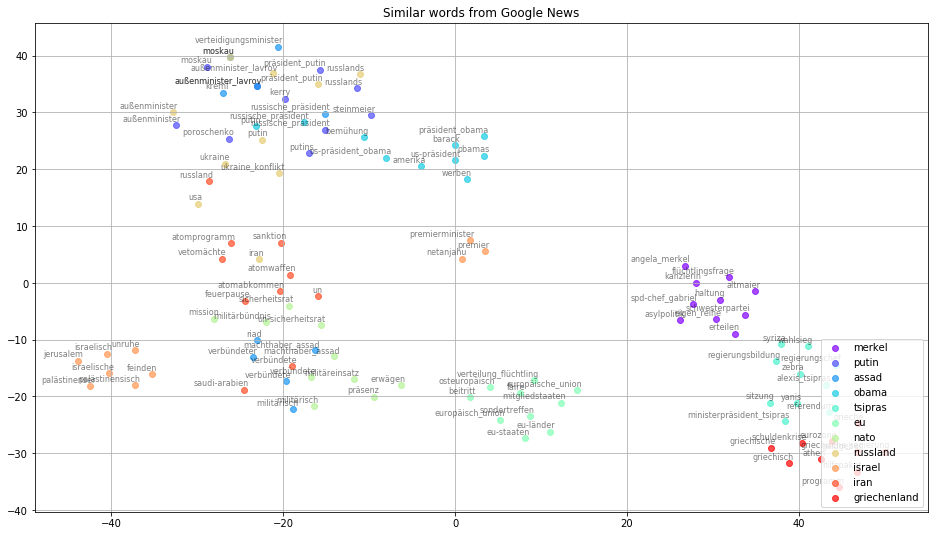

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

In [1]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [2]:
tsne_plot(2010)

NameError: name 'm_2010' is not defined

In [ ]:
model.wv.index2entity[:100]